In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.distributions import normal

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder
from dataset_lib import CenteredStarsData, trim_psf
import optimization_lib

from which_device import device


print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, slen)

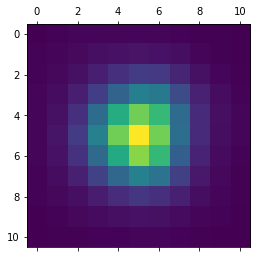

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [5]:
n_images = 20000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

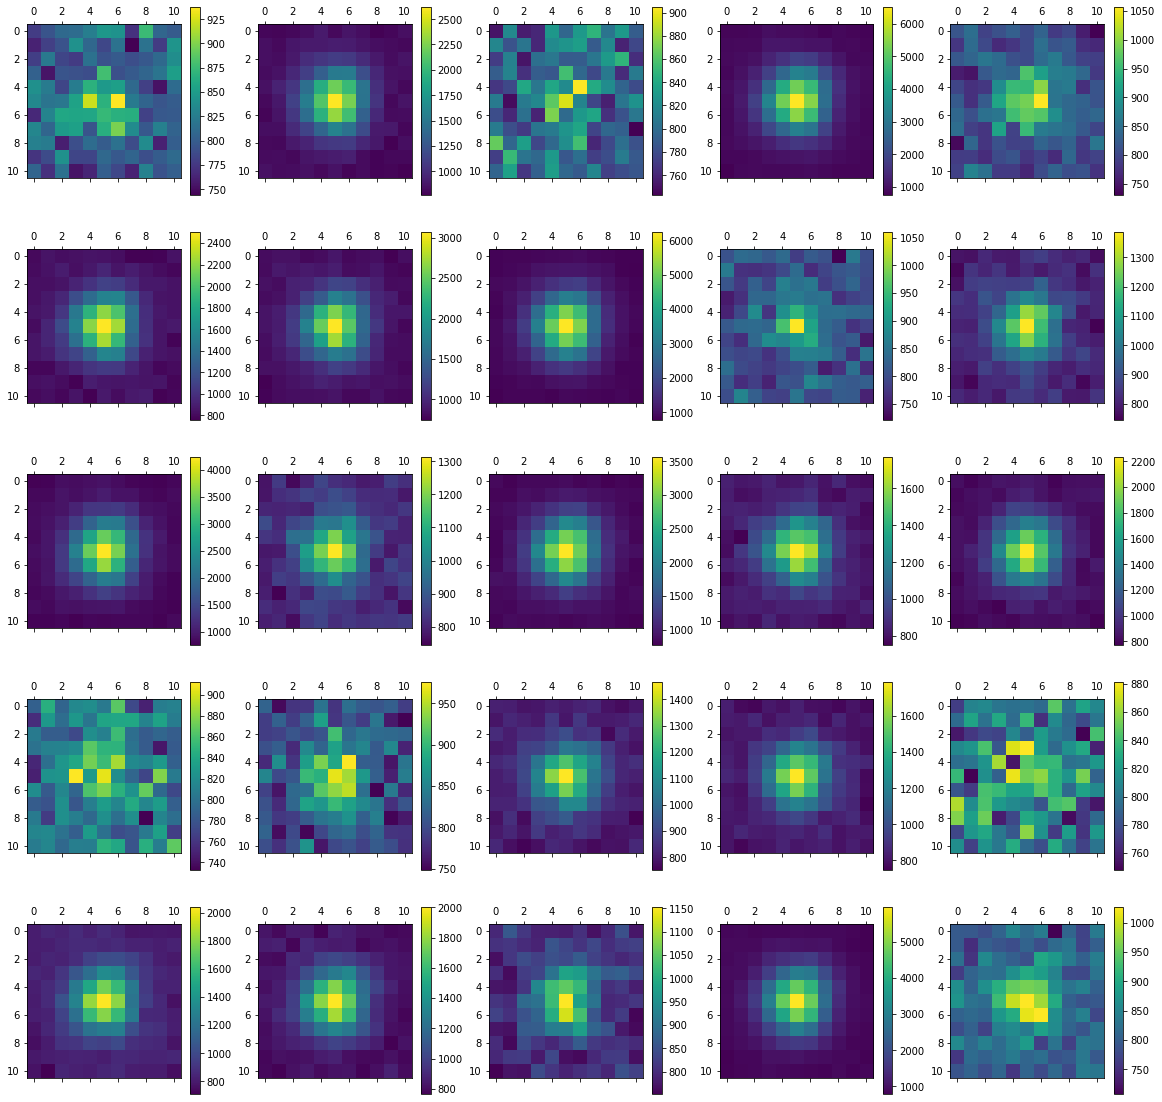

In [6]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25): 
        
    x0 = i // 5
    x1 = i % 5
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [7]:
network = MLPEncoder(slen = slen).to(device)
network

MLPEncoder(
  (fc1): Linear(in_features=121, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

# Define dataset

In [8]:
batch_size = 64
train_data = DataLoader(star_data, 
                         batch_size=batch_size)


test_data = DataLoader(star_data, 
                       batch_size=n_images)

# Choose the loss function

In [9]:
loss_fun = optimization_lib.l2_loss

# Train 

In [10]:
# initial loss 
for _, test_batch in enumerate(test_data):
    break
    
loss = loss_fun(network, test_batch).mean()
print('initial loss: {}'.format(loss))

initial loss: 1078937728.0


In [11]:
# define optimizer 

n_epochs = 10

optimizer = optim.Adam(network.parameters(), 
                       lr = 1e-3)

In [12]:
optimization_lib.train_network(network, loss_fun, train_data, optimizer, n_epochs)

epoch [0]. loss = 334028544.0
epoch [1]. loss = 3612978.75
epoch [2]. loss = 85022.9609375
epoch [3]. loss = 85844.9375
epoch [4]. loss = 86770.921875
epoch [5]. loss = 84874.6796875
epoch [6]. loss = 84681.609375
epoch [7]. loss = 87028.3203125
epoch [8]. loss = 88375.0859375
epoch [9]. loss = 86907.390625
done. Elapsed 40.059sec


# check results

In [13]:
# final loss
network.eval()
loss = loss_fun(network, test_batch).mean()
print('final loss: {}'.format(loss))

final loss: 85083.8359375


In [14]:
true_fluxes = test_batch['flux']

means, sd = network(test_batch['image'])

(array([    0.,     0.,     0.,     0.,     0., 20000.,     0.,     0.,
            0.,     0.]),
 array([-0.499, -0.399, -0.299, -0.199, -0.099,  0.001,  0.101,  0.201,
         0.301,  0.401,  0.501], dtype=float32),
 <BarContainer object of 10 artists>)

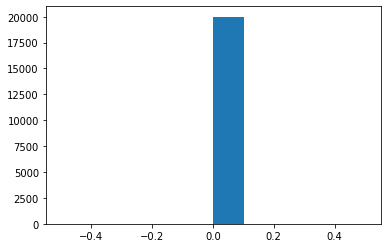

In [15]:
plt.hist(sd.detach().cpu().numpy())

In [16]:
sd

tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010], device='cuda:4',
       grad_fn=<AddBackward0>)

Text(0, 0.5, 'true')

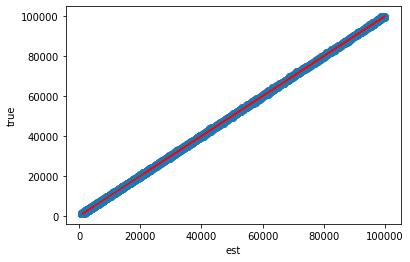

In [17]:
plt.scatter(means.detach().cpu(), 
            true_fluxes.cpu())

# x = y line
plt.plot(true_fluxes.cpu(), 
         true_fluxes.cpu(), color = 'red')

plt.xlabel('est')
plt.ylabel('true')

### Plot some residuals

In [18]:
def reconstruct_image(flux): 
    return star_data.psf * flux + star_data.background

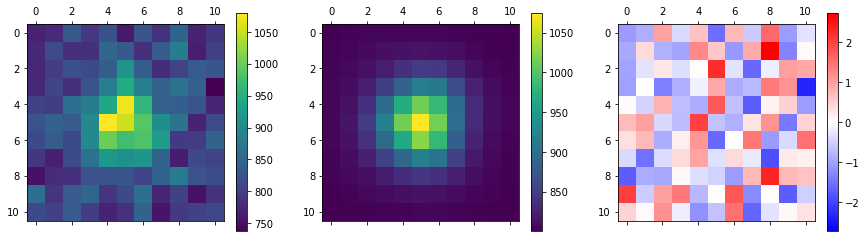

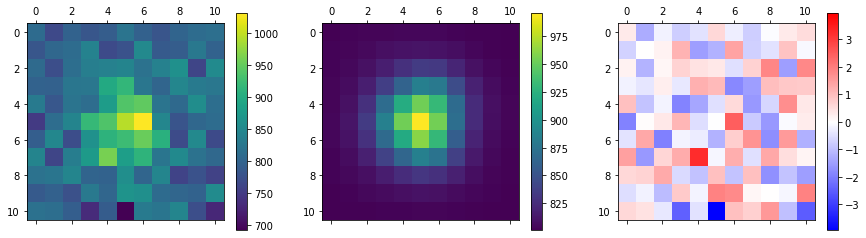

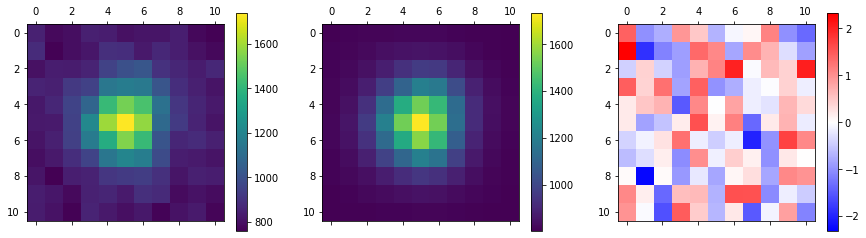

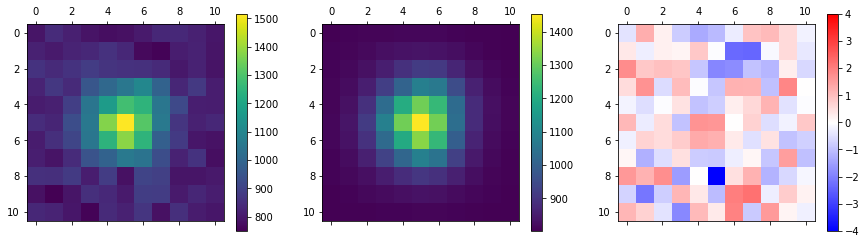

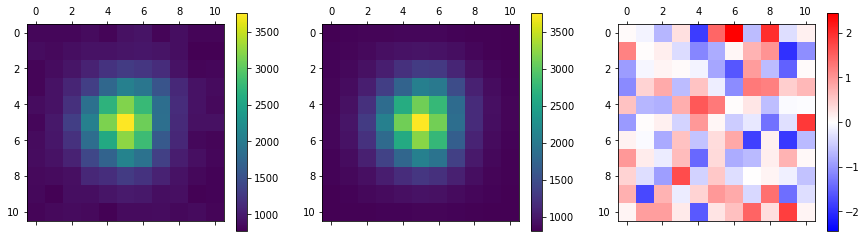

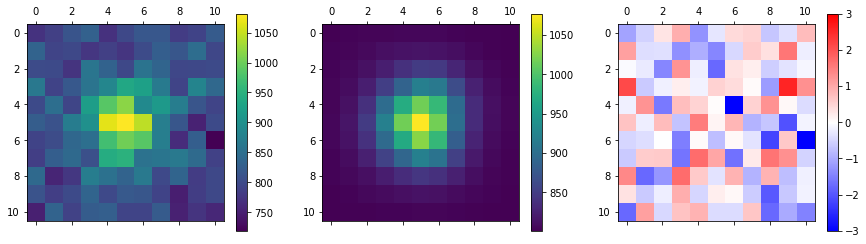

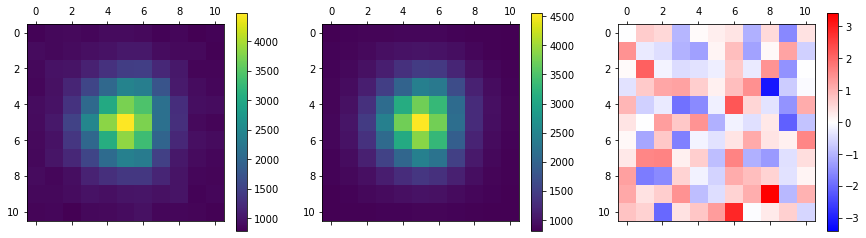

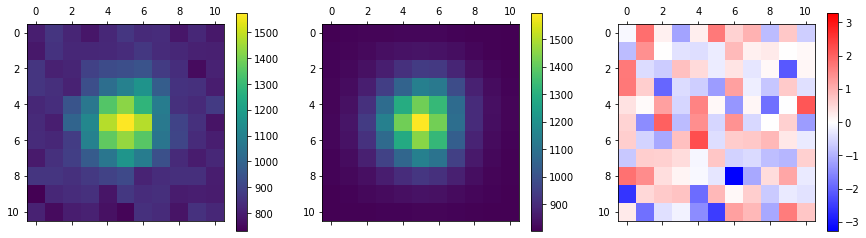

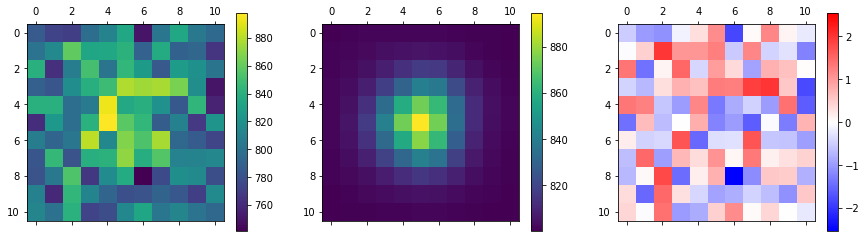

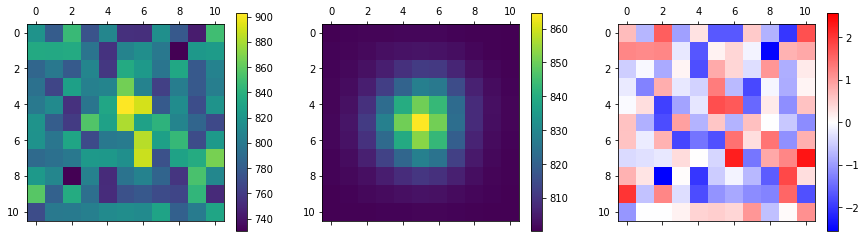

In [19]:
for i in range(10): 
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    image = test_batch['image'][i, 0].cpu()
    
    true_flux = true_fluxes.squeeze()[i]
    est_flux = means.squeeze()[i].detach().cpu()
    
    # plot true image    
    im = ax[0].matshow(image)
    fig.colorbar(im, ax = ax[0])

    # plot reconstructed image 
    recon = reconstruct_image(est_flux).cpu()
    im1 = ax[1].matshow(recon)
    fig.colorbar(im1, ax = ax[1])
    
    # plt residual 
    resid = (image - recon) / torch.sqrt(recon)
    vmax = resid.abs().max()
    im2 = ax[2].matshow(resid, 
                        vmax = vmax, 
                        vmin = -vmax, 
                        cmap = plt.get_cmap('bwr'))
    fig.colorbar(im2, ax = ax[2])